In [234]:
import numpy                as np
import matplotlib.pyplot    as plt

from deproject import deproject_points
from flaring   import angular_to_spatial

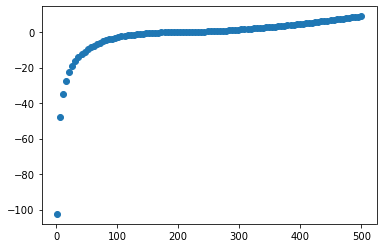

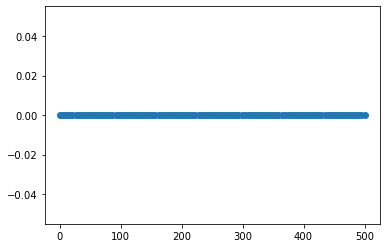

In [235]:
# function for transforming points
def eta(r, phi, R_p, phi_p, hrp, q, cw, return_wake=False):
    
    phi_p *= np.pi/180

    rr = r / R_p
    pphi = (phi - phi_p) % (2*np.pi)
    
    
    
    term1 =  (rr**(q - 0.5)) / (q - 0.5)
    term2 = -(rr**(q + 1)) / (q + 1)
    term3 = -3 / ((2*q - 1) * (q + 1))
    
    phi_wake = -cw * np.sign(r - R_p) * (hrp**-1) * (term1 + term2 + term3)
    phi_wake_mod = phi_wake % (2*np.pi)
    
    if return_wake:
        return phi_wake
    else:
        #print(pphi[10])
        #print(phi_wake_mod[10])
        #print((pphi - phi_wake_mod)[10])
        return (pphi - phi_wake_mod)

example_r = np.linspace(1, 500, 100)
example_phi = eta(example_r, 0, R_p=200, phi_p=0, hrp=0.1, q=0.25, cw=1, return_wake=True)

plt.scatter(example_r, example_phi)
plt.show()

example_eta = eta(example_r, example_phi, R_p=200, phi_p=0, hrp=0.1, q=0.25, cw=1)
plt.scatter(example_r, example_eta)
plt.show()

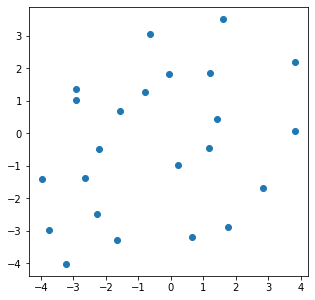

In [236]:
# read in data points
"""
generated with:

hr      = 0.1
q       = 0.25
Rp      = 200
az_p    = 45
"""

data = np.loadtxt('practice_fit_data.csv', delimiter=',')

x_data = data[:,0]
y_data = data[:,1]

plt.figure(figsize=[5,5])
plt.scatter(x_data, y_data)
plt.axis('scaled')
plt.show()

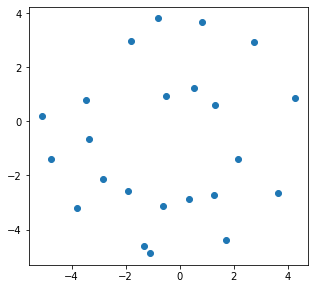

In [237]:
# deproject using inclination and PA

inclination = -225
pos_angle   = 45

deproj_x, deproj_y = deproject_points(inclination=inclination, 
                 pos_angle=pos_angle, 
                 x_points=x_data, 
                 y_points=y_data,
                 resolution=500
)

plt.figure(figsize=[5,5])
plt.scatter(deproj_x, deproj_y)
plt.axis('scaled')
plt.show()

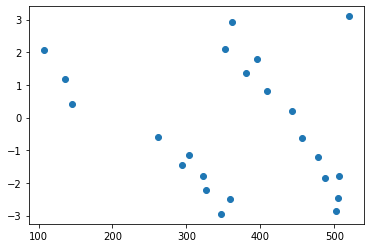

In [238]:
# convert to (r,phi) coordinates
distance = 101.5

r   = np.zeros(deproj_x.shape)
phi = np.zeros(deproj_x.shape)

for i in range(deproj_x.shape[0]):
    r[i]   = np.sqrt(deproj_x[i]**2 + deproj_y[i]**2)
    phi[i] = np.arctan2(deproj_y[i], deproj_x[i])
    
r = angular_to_spatial(r, distance=distance)

plt.scatter(r, phi)

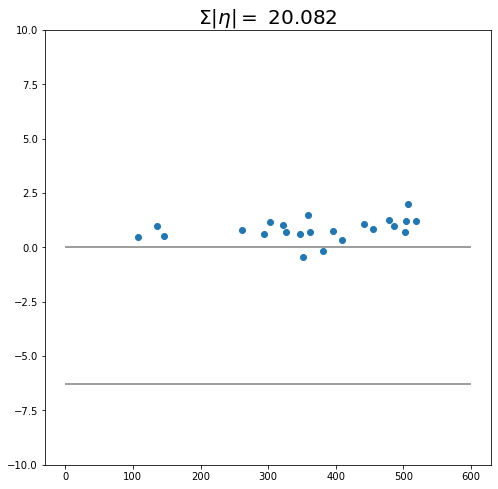

In [239]:
#r, phi, R_p, phi_p, hrp, q, cw
"""
generated with:

hr      = 0.1
q       = 0.25
Rp      = 200
az_p    = 45
"""
eta_points = eta(r, phi, R_p=200, phi_p=-45, hrp=0.1, q=0.25, cw=-1)

for i in range(eta_points.shape[0]):
    
    if eta_points[i] < -np.pi:
        eta_points[i] += 2*np.pi
    elif eta_points[i] > np.pi:
        eta_points[i] -= 2*np.pi

sum_eta = round(np.sum(np.abs(eta_points)), 3)

plt.figure(figsize=[8,8])
plt.title(fr'$\Sigma | \eta | =$ {sum_eta}', size=20)
plt.scatter(r, eta_points)
plt.hlines(0, 0, 600, color='grey')
plt.ylim(-10,10)
plt.show()

In [240]:
def evaluate_fit(r, phi, R_p, phi_p, hrp, q, cw):
    
    eta_points = eta(r=r, phi=phi, R_p=R_p, phi_p=phi_p, hrp=hrp, q=q, cw=cw)

    for i in range(eta_points.shape[0]):

        if eta_points[i] < -np.pi:
            eta_points[i] += 2*np.pi
        elif eta_points[i] > np.pi:
            eta_points[i] -= 2*np.pi

    sum_eta = round(np.sum(np.abs(eta_points)), 3)
    
    return sum_eta

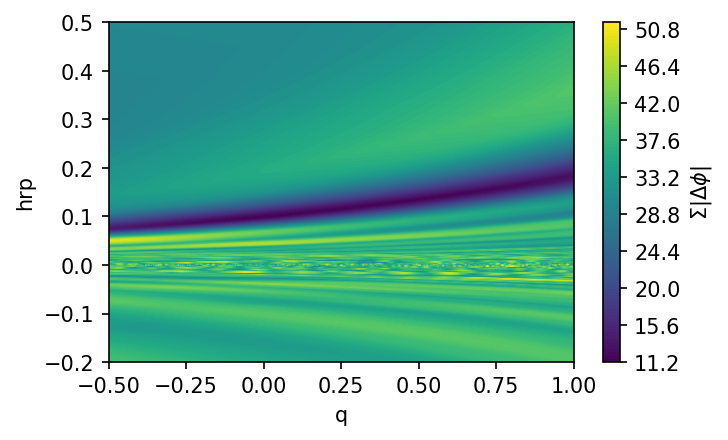

In [241]:
n_hrp = 401
n_q = 401

hrp_vals = np.linspace(-0.2, 0.5, n_hrp)
q_vals = np.linspace(-0.5, 1, n_q)

eta_vals = np.zeros((n_hrp,n_q))

for i, hrp in enumerate(hrp_vals):
    for j, q in enumerate(q_vals):
        
        eta_vals[i,j] = evaluate_fit(r, phi, R_p=200, phi_p=-45, hrp=hrp, q=q, cw=-1)

plt.figure(figsize=[5,3], dpi=150)
plt.contourf(q_vals, hrp_vals, eta_vals, levels=100)
plt.xlabel('q')
plt.ylabel('hrp')
plt.colorbar(label=r'$\Sigma | \Delta \phi | $')
plt.show()

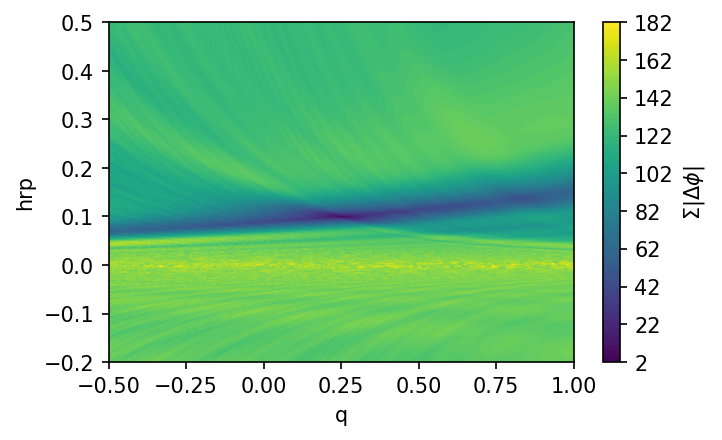

In [242]:
n_hrp = 401
n_q = 401

hrp_vals = np.linspace(-0.2, 0.5, n_hrp)
q_vals = np.linspace(-0.5, 1, n_q)

eta_vals = np.zeros((n_hrp,n_q))

for i, hrp in enumerate(hrp_vals):
    for j, q in enumerate(q_vals):
        
        eta_vals[i,j] = evaluate_fit(example_r, example_phi, R_p=200, phi_p=0, hrp=hrp, q=q, cw=1)

plt.figure(figsize=[5,3], dpi=150)
plt.contourf(q_vals, hrp_vals, eta_vals, levels=100)
plt.xlabel('q')
plt.ylabel('hrp')
plt.colorbar(label=r'$\Sigma | \Delta \phi | $')
plt.show()